# Анализ matchmaking system в игре ClashRoyale

In [2]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

Данные о боях загружаются из базы данных (MongoDB)

In [2]:
client = MongoClient('localhost', 27017)

In [3]:
db = client["clashroyale"]

In [4]:
battle_log = db["battlelog"]

In [23]:
battle = next(battle_log.find({}).sort("createdDate", -1))

### 1. Формирование датасета боёв.

In [24]:
battle_list = []
for b in battle_log.find({}):
    battle_list.append([
        b['type'], b['battleTime'][0:8], b['deckSelection'], b['team'][0]['tag'], b['team'][0]['name'],
        b['team'][0]['startingTrophies'], b['team'][0]['crowns'], 
        b['opponent'][0]['tag'],
        b['opponent'][0]['name'], b['opponent'][0]['startingTrophies'], b['opponent'][0]['crowns']
        ])

In [25]:
data_battle = pd.DataFrame(battle_list, columns=['type', 'battleTime', 'deckSelection', 'player_tag', 'player_name',
                                                 'player_startingTrophies', 'player_crowns', 
                                                 'opponent_tag', 'opponent_name',
                                                 'opponent_startingTrophies', 'opponent_crowns'
                                                 ])

In [26]:
data_battle = data_battle.sort_values(by=['battleTime'])
data_battle = data_battle.loc[data_battle['opponent_tag'] != '#82P028G08']   # по игроку нет статистики
data_battle = data_battle.loc[data_battle['opponent_tag'] != '#9PQUY0Q8P']   # по игроку нет статистики
data_battle.head()

,type,battleTime,deckSelection,player_tag,player_name,player_startingTrophies,player_crowns,opponent_tag,opponent_name,opponent_startingTrophies,opponent_crowns
2154,clanWarWarDay,20200309,collection,#8RPGUJQ9U,Alpen Gold,5169,1,#2VC080VVV,Davidp,4918,2
96,clanWarCollectionDay,20200325,collection,#9YGYGVPY,Внук_Светличной,5842,0,#VLRR9RU0,简简陌,5713,1
2145,clanWarWarDay,20200326,collection,#9YGYGVPY,Внук_Светличной,5842,3,#Q0RV2P2Q,冰雨,5706,1
2144,clanWarCollectionDay,20200329,draft,#9YGYGVPY,Внук_Светличной,5842,1,#8YCV2QQ88,БАЛДЬОЖ,5668,2
95,clanWarCollectionDay,20200329,collection,#9YGYGVPY,Внук_Светличной,5842,0,#89JG8VUP,Cap Nascimento,5510,1


In [27]:
print('data_battle.shape =', data_battle.shape)
print('количество игроков (nunique player) =', data_battle.player_tag.nunique())
print('количество оппонентов (nunique opponent) =', data_battle.opponent_tag.nunique())

data_battle.shape = (4057, 11)
количество игроков (nunique player) = 75
количество оппонентов (nunique opponent) = 4012


Разделим датасет на бои в первый (collection) и второй (war) дни клановых войн.

In [29]:
data_battle_collection = data_battle[data_battle.type == 'clanWarCollectionDay']
data_battle_war = data_battle[data_battle.type == 'clanWarWarDay']

In [31]:
# общий список tag игроков и оппонентов
all_players = pd.concat([data_battle.player_tag, data_battle.opponent_tag]).drop_duplicates().to_list()
print('общее количество игроков и оппонентов =', len(all_players))

общее количество игроков и оппонентов = 4087


### 2. Загрузка статистики игроков с clash api.

In [3]:
# загружаем статистику по 4087 игрокам предварительно загруженную с https://api.clashroyale.com
data_players = pd.read_csv('data_players')

In [38]:
data_players.head()

,tag,name,expLevel,trophies,bestTrophies,wins,losses,battleCount,threeCrownWins,challengeCardsWon,...,tournamentCardsWon,tournamentBattleCount,donations,donationsReceived,totalDonations,warDayWins,clanCardsCollected,games,win_rate,win_game_rate
0,#8RPGUJQ9U,Alpen Gold,12,4632,5622,2288,1930,9350,1890,1603,...,0,168,0,0,57320,44,156878,4218,1.185492,0.542437
1,#9YGYGVPY,Внук_Светличной,12,4389,6321,6499,7432,14987,3095,5077,...,615,1268,8,80,38175,49,237001,13931,0.874462,0.466514
2,#288G2Q2,Виталий,13,4393,6023,3341,2244,9436,1278,9370,...,90,280,0,0,94669,82,234346,5585,1.488859,0.598209
3,#8R220QUYV,Kegla,12,5201,5650,1957,935,10951,3038,2497,...,0,273,30,120,19184,209,581883,2892,2.093048,0.676694
4,#P0JQCQGU8,Eeee boy,10,4000,5317,645,369,1242,213,1297,...,4,42,30,40,6093,23,31200,1014,1.747967,0.636095


По наблюдению игроков наиболее значимым параметром для определения победителя является bestTrophies, проверим есть ли зависимость между соотношением bestTrophies игрока и оппонетна и исходом битвы на самом деле. Для этого проанализируем зависимость разницы bestTrophies и crowns. Crowns это по сути счёт "игры" и большее преимущество одного игрока над другим в crowns должно вытекать из большего преимущества в bestTrophies.

### 3. Начнём с первого дня (collection day) besrTrophies - crowns collection day

In [48]:
# отберём нужные нам столбцы из data_battle_collection
data_besrTrophies_crowns = data_battle_collection[['battleTime', 'player_tag', 'player_name', 'player_crowns',
                                                  'opponent_tag', 'opponent_name', 'opponent_crowns']]

In [49]:
# функция возвращает bestTrophies из data_players по tag
def get_bestTrophies(tag):
    return data_players.bestTrophies[data_players.tag == tag].to_list()[0]

In [50]:
# дополним data_besrTrophies_crowns данными о bestTrophies игроков и их оппонентов
data_besrTrophies_crowns['player_bestTrophies'] = data_besrTrophies_crowns.player_tag.apply(lambda x: get_bestTrophies(x))
data_besrTrophies_crowns['opponent_bestTrophies'] = data_besrTrophies_crowns.opponent_tag.apply(lambda x: get_bestTrophies(x))

<ipython-input-50-314a2f6edd0e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_besrTrophies_crowns['player_bestTrophies'] = data_besrTrophies_crowns.player_tag.apply(lambda x: get_bestTrophies(x))
<ipython-input-50-314a2f6edd0e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_besrTrophies_crowns['opponent_bestTrophies'] = data_besrTrophies_crowns.opponent_tag.apply(lambda x: get_bestTrophies(x))


In [51]:
# рассчитаем разницу bestTrophies (diff_bestTrophies) и crowns (diff_crowns) игроков и их оппонетнов
data_besrTrophies_crowns['diff_bestTrophies'] = data_besrTrophies_crowns['player_bestTrophies'] \
                                                - data_besrTrophies_crowns['opponent_bestTrophies']
data_besrTrophies_crowns['diff_crowns'] = data_besrTrophies_crowns['player_crowns'] \
                                                - data_besrTrophies_crowns['opponent_crowns']

<ipython-input-51-ab4fae0709d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_besrTrophies_crowns['diff_bestTrophies'] = data_besrTrophies_crowns['player_bestTrophies'] \


In [52]:
data_besrTrophies_crowns.head()

,battleTime,player_tag,player_name,player_crowns,opponent_tag,opponent_name,opponent_crowns,player_bestTrophies,opponent_bestTrophies,diff_bestTrophies,diff_crowns
96,20200325,#9YGYGVPY,Внук_Светличной,0,#VLRR9RU0,简简陌,1,6321,6008,313,-1
2144,20200329,#9YGYGVPY,Внук_Светличной,1,#8YCV2QQ88,БАЛДЬОЖ,2,6321,5809,512,-1
95,20200329,#9YGYGVPY,Внук_Светличной,0,#89JG8VUP,Cap Nascimento,1,6321,5772,549,-1
94,20200329,#9YGYGVPY,Внук_Светличной,0,#9RVG9U2VV,TYSON FURY,1,6321,5966,355,-1
93,20200331,#9YGYGVPY,Внук_Светличной,0,#80UP9R9V,io resto a casa,3,6321,5913,408,-3


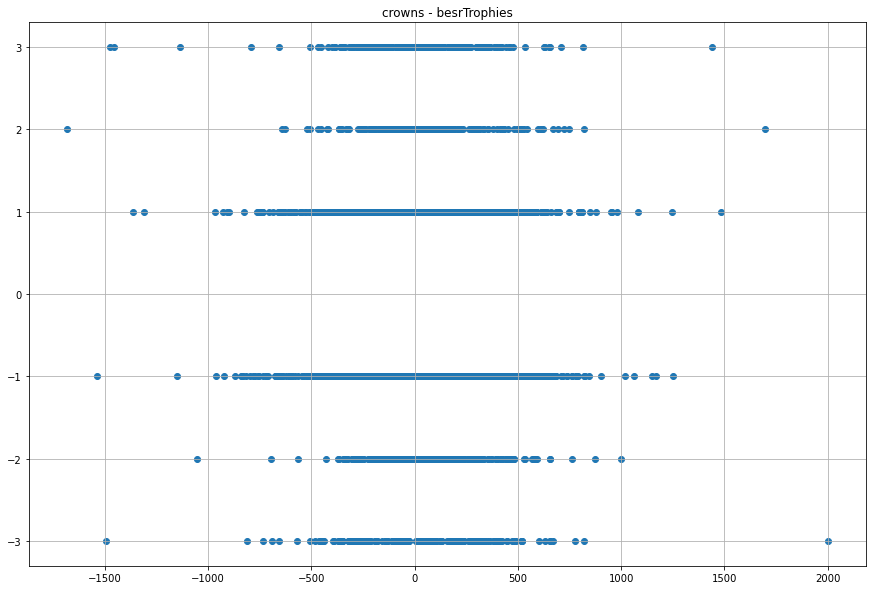

In [53]:
plt.figure(figsize=(15,10))
plt.scatter(data_besrTrophies_crowns.diff_bestTrophies, data_besrTrophies_crowns.diff_crowns)
plt.title('crowns - besrTrophies')
plt.grid()

Какой-либо зависимости не наблюдается. Среднее значение diff_bestTrophies близко в нулю не зависимо от diff_crowns.

### 4. Рассмотрим второй день (war day) bestTrophies - crowns war day

данные подготовим по аналогии с collection day

In [54]:
# отберём нужные нам столбцы из data_battle_collection
data_besrTrophies_crowns_war = data_battle_war[['battleTime', 'player_tag', 'player_name', 'player_crowns',
                                                  'opponent_tag', 'opponent_name', 'opponent_crowns']]

In [56]:
# дополним data_besrTrophies_crowns данными о bestTrophies игроков и их оппонентов
data_besrTrophies_crowns_war['player_bestTrophies'] = data_besrTrophies_crowns_war.player_tag.apply(lambda x: 
                                                                                                    get_bestTrophies(x))
data_besrTrophies_crowns_war['opponent_bestTrophies'] = data_besrTrophies_crowns_war.opponent_tag.apply(lambda x: 
                                                                                                        get_bestTrophies(x))

<ipython-input-56-09411ed32314>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_besrTrophies_crowns_war['player_bestTrophies'] = data_besrTrophies_crowns_war.player_tag.apply(lambda x:
<ipython-input-56-09411ed32314>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_besrTrophies_crowns_war['opponent_bestTrophies'] = data_besrTrophies_crowns_war.opponent_tag.apply(lambda x:


In [57]:
# рассчитаем разницу bestTrophies (diff_bestTrophies) и crowns (diff_crowns) игроков и их оппонетнов
data_besrTrophies_crowns_war['diff_bestTrophies'] = data_besrTrophies_crowns_war['player_bestTrophies'] \
                                                - data_besrTrophies_crowns_war['opponent_bestTrophies']
data_besrTrophies_crowns_war['diff_crowns'] = data_besrTrophies_crowns_war['player_crowns'] \
                                                - data_besrTrophies_crowns_war['opponent_crowns']

<ipython-input-57-d49271d3d253>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_besrTrophies_crowns_war['diff_bestTrophies'] = data_besrTrophies_crowns_war['player_bestTrophies'] \


In [58]:
data_besrTrophies_crowns_war.head()

,battleTime,player_tag,player_name,player_crowns,opponent_tag,opponent_name,opponent_crowns,player_bestTrophies,opponent_bestTrophies,diff_bestTrophies,diff_crowns
2154,20200309,#8RPGUJQ9U,Alpen Gold,1,#2VC080VVV,Davidp,2,5622,6253,-631,-1
2145,20200326,#9YGYGVPY,Внук_Светличной,3,#Q0RV2P2Q,冰雨,1,6321,5931,390,2
2143,20200330,#9YGYGVPY,Внук_Светличной,1,#C0YVL8JV,&(الحيران)&,2,6321,6073,248,-1
102,20200401,#288G2Q2,Виталий,3,#P020YUJ9U,vlan1991,0,6023,5396,627,3
101,20200403,#288G2Q2,Виталий,2,#8YLRCJ0YU,Galaxy,1,6023,5826,197,1


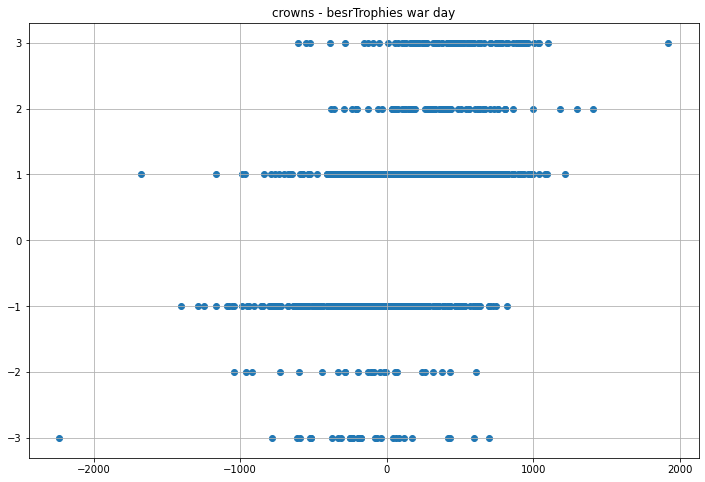

In [59]:
plt.figure(figsize=(12,8))
plt.scatter(data_besrTrophies_crowns_war.diff_bestTrophies, data_besrTrophies_crowns_war.diff_crowns)
plt.title('crowns - besrTrophies war day')
plt.grid()

Здесь наблюдаем совсем другую картину - среднее diff_bestTrophies очевидно больше нуля и положительном diff_crowns и наоборот меньше нуля при отрицатьном diff_crowns, только при diff_crowns = -3 сложно сделать какие-либо выводы о положении среднего значения diff_bestTrophies.

Чтобы подтвердить полученные данные построим график зависимости доли побед игроков от diff_bestTrophies

In [65]:
# отсортируем data_besrTrophies_crowns_war по возрастанию diff_bestTrophies
data_besrTrophies_crowns_war = data_besrTrophies_crowns_war.sort_values(by=['diff_bestTrophies'])

In [66]:
# функция разделяющая данные на n_split равных частей
def make_split(data, n_split):
    len_split = int(len(data) / n_split)
    frame = [data.iloc[i * n_split: (i + 1) * n_split].copy() for i in range(len_split + 1)]
    return frame

In [67]:
from statsmodels.stats.proportion import proportion_confint

# расчёт доли побед игроков и доверительного интервала (method = 'wilson')
def calc_statistic(data):
    data = data[['diff_bestTrophies', 'diff_crowns']]
    if data.shape[0] == 0:
        return (np.nan, np.nan, np.nan)
    else:
        res = data[(data.diff_crowns) > 0].shape[0] / data.shape[0]
        loss = [0] * data[(data.diff_crowns) < 0].shape[0]
        win = [1] * data[(data.diff_crowns) > 0].shape[0]
        diff_best_trophies = (data.diff_bestTrophies.mean())
        wilson_interval = proportion_confint(sum(win + loss), len(win + loss), method = 'wilson')
        return (np.around(res, 2), wilson_interval[0],  wilson_interval[1], np.around(diff_best_trophies, 2))

In [69]:
result = []               # доля побед икроков
left = []                 # нижняя граница доверитьного интервала
right = []                # верхняя граница доверитьного интервала
diff_best_trophies = []   # среднее diff_bestTrophies для сплита, для отображения на графике

# делим данные на 50 сплитов
split_data = make_split(data_besrTrophies_crowns_war, 50)

# рассчёт статистик
for split in range(len(split_data)):
    bins = calc_statistic(split_data[split])
    result.append(bins[0])
    left.append(bins[1])
    right.append(bins[2])
    diff_best_trophies.append(str(bins[3]))
    # print('bins of diff_bestTrophies =', bins, 'players win percentage =', result[-1])

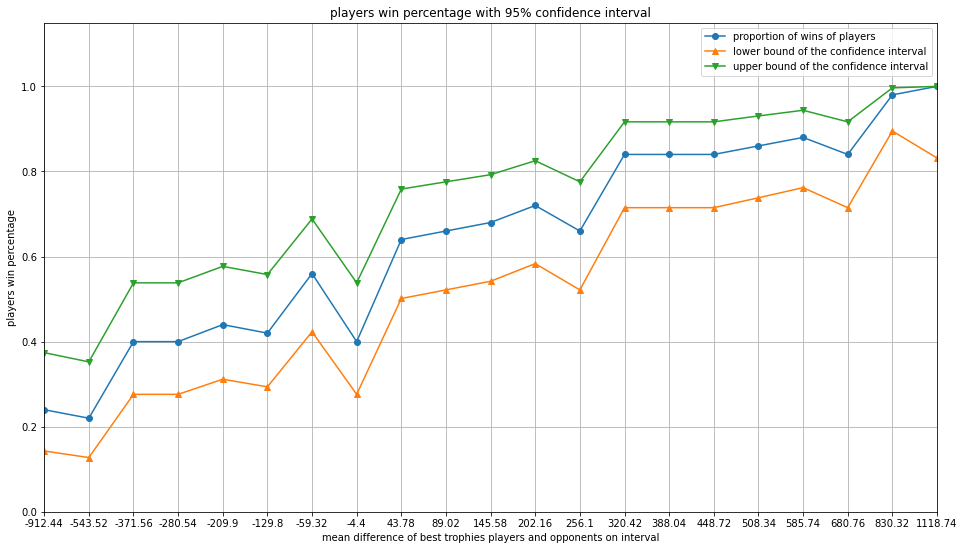

In [70]:
plt.figure(figsize=(16,9))
plt.plot(diff_best_trophies, result, marker='o')   # доля побед икроков
plt.plot(diff_best_trophies, left, marker='^')     # нижняя граница доверитьного интервала
plt.plot(diff_best_trophies, right, marker='v')    # верхняя граница доверитьного интервала
plt.title('players win percentage with 95% confidence interval')
plt.xlabel('mean difference of best trophies players and opponents on interval')
plt.ylabel('players win percentage')
plt.legend(('proportion of wins of players',
            'lower bound of the confidence interval',
            'upper bound of the confidence interval'),
            loc='upper right')
plt.xlim((0,20))
plt.ylim((0,1.15))
plt.grid()

Вывод: доля побед игроков монотонно возрастает при росте разницы besrTrophies, что мы и ожидали увидеть. Предположение о том, что разница в besrTrophies соперников влияет на исход подтверждается.